## 1. Importi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import os.path
import json
from collections import defaultdict
import mplcyberpunk
plt.style.use("cyberpunk")


## 2. Branje podatkov

In [10]:
with open('../data/kd2018.csv', 'rt', encoding="cp1250") as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head0 = next(reader)
    none_handler = lambda i : i or None
    main_data18 = np.array([none_handler(i) for i in [row for row in reader]])

In [11]:
with open('../data/kd2019.csv', 'rt', encoding="cp1250") as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head1 = next(reader)
    none_handler = lambda i : i or None
    main_data19 = np.array([none_handler(i) for i in [row for row in reader]])

In [12]:
with open('../data/kd2020.csv', 'rt', encoding="cp1250") as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head2 = next(reader)
    none_handler = lambda i : i or None
    main_data20 = np.array([none_handler(i) for i in [row for row in reader]])

In [13]:
with open('../data/kd2021.csv', 'rt', encoding="cp1250") as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    head3 = next(reader)
    none_handler = lambda i : i or None
    main_data21 = np.array([none_handler(i) for i in [row for row in reader]])

In [14]:
with open('../data/obcine_slovenije.csv', 'rt', encoding='utf8') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    head_obcine = next(reader)
    none_handler = lambda i : i or None
    obcine = np.array([none_handler(i) for i in [row for row in reader]])

## 3. Priprava podatkov

Odstranjevanje duplikatov:

In [15]:
found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data18)):
    if (main_data18[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data18[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data18_filtered = main_data18[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data19)):
    if (main_data19[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data19[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data19_filtered = main_data19[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data20)):
    if (main_data20[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data20[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data20_filtered = main_data20[np.ma.make_mask(rows_to_keep)]

found_ids = set()
rows_to_keep = np.array([])
for i in range(len(main_data21)):
    if (main_data21[i][0] not in found_ids):
        rows_to_keep = np.append(rows_to_keep, True)
        found_ids.add(main_data21[i][0])
    else:
        rows_to_keep = np.append(rows_to_keep, False)

main_data21_filtered = main_data21[np.ma.make_mask(rows_to_keep)]

main_data = np.concatenate((main_data18_filtered, main_data19_filtered, main_data20_filtered, main_data21_filtered))

Izračunana vrednost "nevarnosti" za vse zločine s formulo: 
$$ x = ((max\_jailtime + avg\_actual\_jailtime) * dangerousness) $$
V primeru, da je avg_actual_jailtime = NaN, namesto tega dodam max_jailtime, saj to pomeni, da se v naših podatkih zločinov ta zločin ni nikoli zgodil in predpostavimo, da je to zelo hud zločin. Primer takega zločina je "genocid".

In [16]:
# read json data from kazni_dict.json
with open('../data/kazni_dict.json', 'r', encoding='utf8') as f:
    kazni_dict = json.load(f)

In [17]:
kazni_utezi = dict()
for kd, values in kazni_dict.items():
        if (pd.isna(values['average_actual_jailtime'])):
            x = values['max_jailtime'] * 2 * values['dangerousness']
        else:
            x = (values['max_jailtime'] + values['average_actual_jailtime']) * values['dangerousness']
        kazni_utezi[kd] = x

In [18]:
obc = dict.fromkeys([str.lower(x) for x in np.unique(obcine[:, 0])], 0)
city_errors = set()
kd_errors_dict = defaultdict(int)


for kd in main_data:
    city = str.lower(kd[19])
    kd = str.lower(str.strip(str.split(kd[6], '-')[-1]))
    if (city == 'neznana ue' or city == 'neznana obč' or city == 'ni podatka' or kd == 'poneverba in neupravičena uporaba tujega premoženja' or kd == ''):
        continue
    if (city == 'šentjur pri celju'):
        city = 'šentjur'
    try:
        obc[city] += kazni_utezi[kd]
    except KeyError:
            kd_errors_dict[kd] += 1
            print(f"NAPAKA PRI \"{kd}\"")

# kd_errors = np.array(list(kd_errors_dict.items()), dtype=object)
# kd_errors = kd_errors[np.argsort(kd_errors[:, 1])[::-1]]
# kd_errors

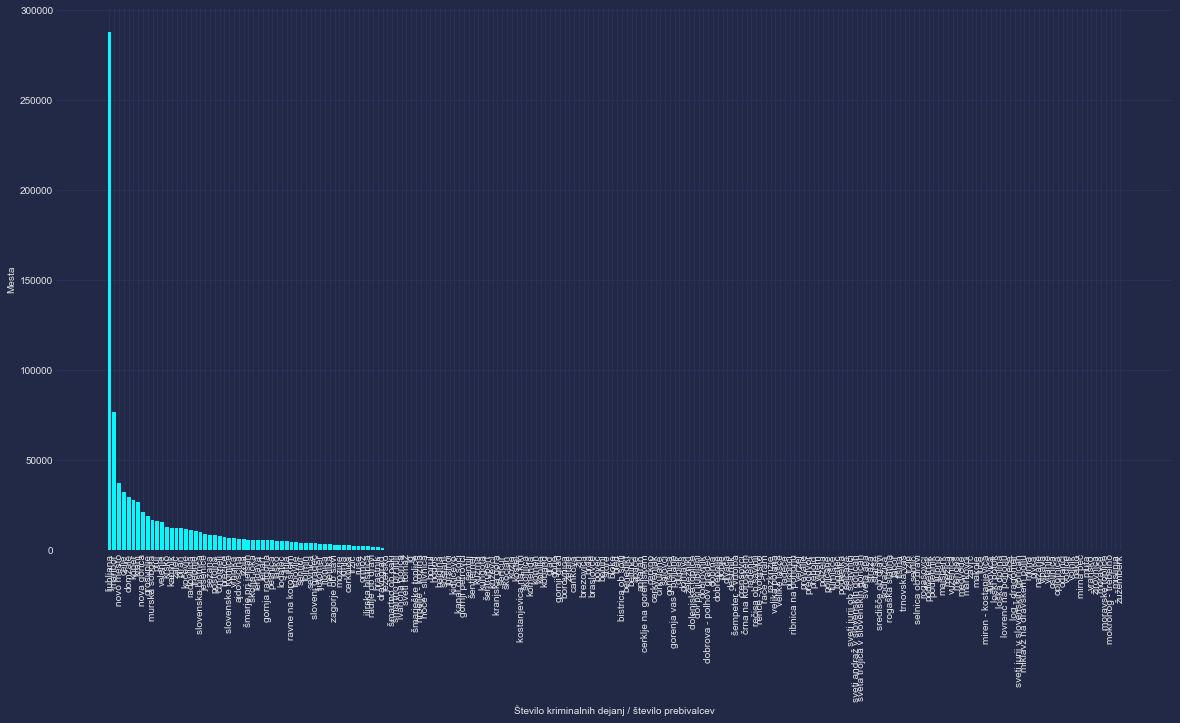

In [19]:
np_obc_danger = np.array(list(obc.items()), dtype=object)
np_obc_danger = np_obc_danger[np.argsort(np_obc_danger[:, 1])[::-1]]


# create graph of dangerousness of cities
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)
plt.xlabel("Število kriminalnih dejanj / število prebivalcev")
plt.ylabel("Mesta")
plt.bar(np_obc_danger[:, 0], np_obc_danger[:, 1])
plt.show()


Sedaj delim rezultate z številom prebivalcev. Število prebivalcev datuma 1. julij (2020).

In [20]:
obc_prebivalci = dict((str.lower(x[0]), int(x[2])) for x in obcine)

In [21]:
np_obc_danger_1 = np.array([[x[0], round(x[1] / obc_prebivalci[x[0]], 5)] for x in np_obc_danger], dtype=object)

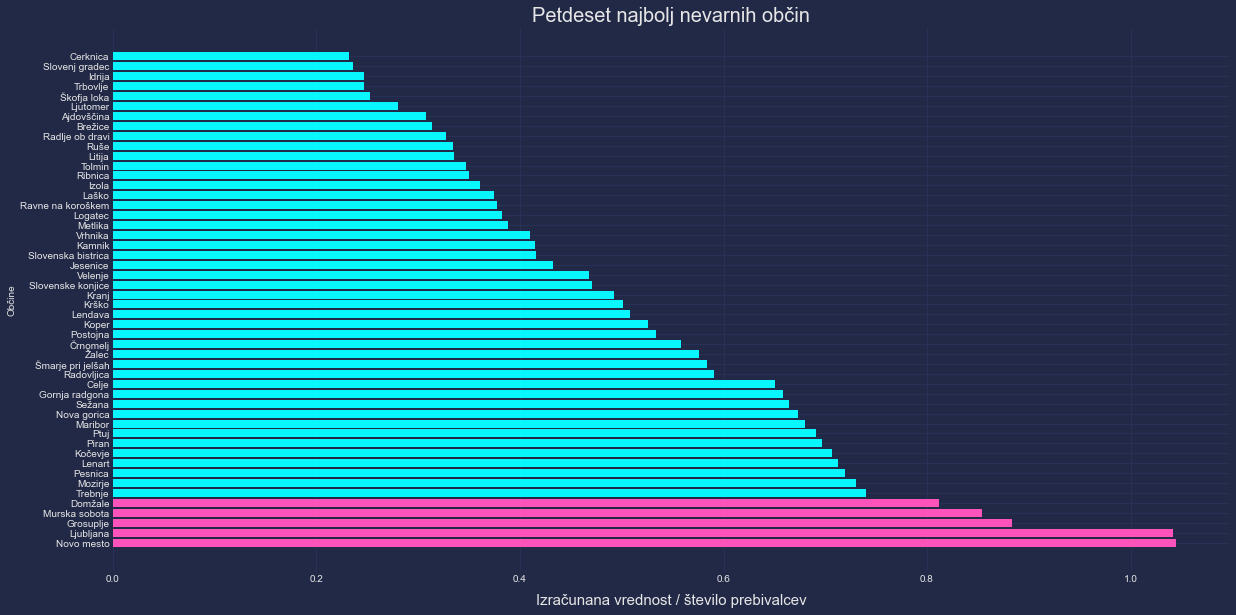

In [30]:
np_obc_danger_1 = np_obc_danger_1[np.argsort(np_obc_danger_1[:, 1])[::-1]]

x_axis = np_obc_danger_1[:, 1]
y_axis = np_obc_danger_1[:, 0]


colors = []
for i, value in enumerate(y_axis):
    if value == "Novo mesto" or value == "Ljubljana" or value == "Grosuplje" or value == "Murska sobota" or value == "Domžale":
        colors.append('#FE53BB')
    else:
        colors.append('#08F7FE')
    y_axis[i] = value.capitalize()

# create graph of dangerousness of cities
fig = plt.figure(figsize=(20, 10))
# fig.patch.set_facecolor('white')
plt.title("Petdeset najbolj nevarnih občin", fontsize=20)
plt.xlabel("Izračunana vrednost / število prebivalcev", fontsize=15, labelpad=10)
plt.ylabel("Občine", fontsize=15, labelpad=10)
plt.barh(y_axis[:50], x_axis[:50], color=colors)
plt.show()

## 4. Razložitev rezultatov

Vrednost predstavlja, kako nevarni